In [29]:
import pandas as pd
import numpy as np
import shap
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import joblib


In the features, 1 means "yes" and 0 means "no"

In [ ]:
# ---------- 1. Model for ICU Prediction ----------

=== Training Metrics ===
F1 Score: 0.9170156281301063
Accuracy: 0.9171763977827169
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.87      0.91    132521
         1.0       0.88      0.96      0.92    132488

    accuracy                           0.92    265009
   macro avg       0.92      0.92      0.92    265009
weighted avg       0.92      0.92      0.92    265009


=== Test Metrics ===
F1 Score: 0.8919058326543313
Accuracy: 0.8921407332498151
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.85      0.89     33110
         1.0       0.86      0.94      0.90     33143

    accuracy                           0.89     66253
   macro avg       0.90      0.89      0.89     66253
weighted avg       0.90      0.89      0.89     66253



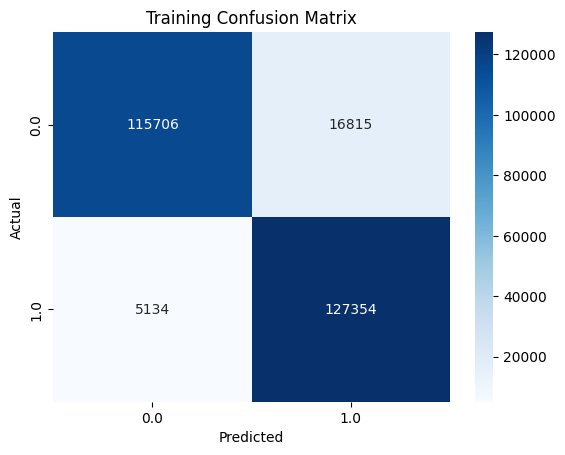

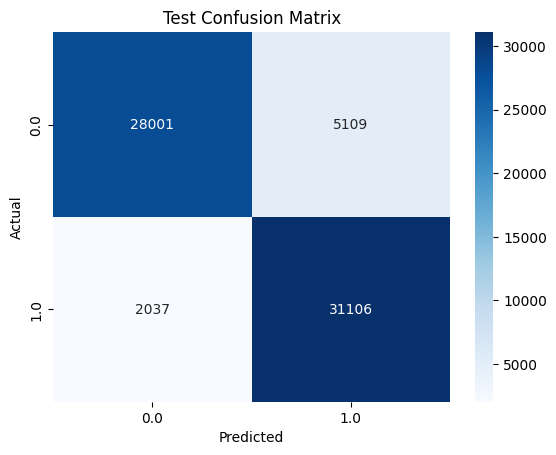

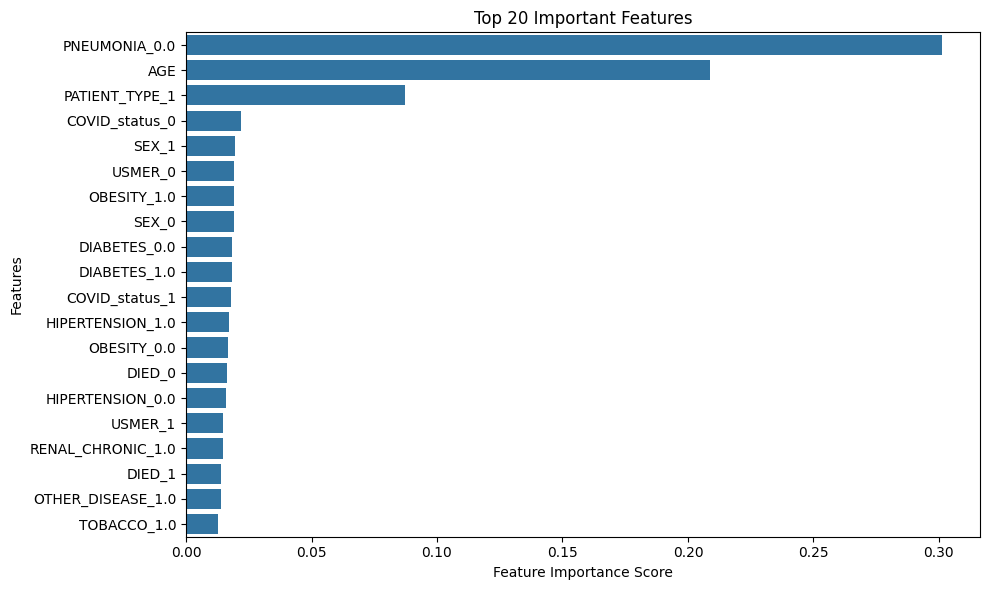

In [17]:
# Step 1: Load and clean initial data
df = pd.read_csv("imputed_covid_data_m2_modified.csv")
df = df.replace("nan", np.nan)

# Step 2: Split data into working (80%) and validation (20%)
working_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 3: Preprocess working_df
# Drop INTUBED, keep ICU for now
working_df = working_df.drop(columns=["INTUBED"])
working_df = working_df.dropna(subset=["ICU"])  # Drop rows with missing ICU
icu_target = working_df["ICU"]
working_df = working_df.drop(columns=["ICU"])

# Drop all rows with any missing values (after removing ICU)
working_df = working_df.dropna()
icu_target = icu_target.loc[working_df.index]  # Align ICU target with cleaned DataFrame

# Convert categorical columns to string
for col in working_df.columns:
    if col != "AGE":
        working_df[col] = working_df[col].astype(str)

# One-hot encode
working_encoded = pd.get_dummies(working_df, columns=[col for col in working_df.columns if col != 'AGE'])

# Step 4: Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(working_encoded, icu_target)

# Step 5: Scale all features (including AGE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_smote)

# Step 6: Split into train/test (from the oversampled data)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_smote, test_size=0.2, random_state=42)

# Step 7: Train classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 8: Predictions and metrics
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print("=== Training Metrics ===")
print("F1 Score:", f1_score(y_train, y_train_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

print("\n=== Test Metrics ===")
print("F1 Score:", f1_score(y_test, y_test_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Step 9: Plot confusion matrices
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_train, y_train_pred, "Training Confusion Matrix")
plot_conf_matrix(y_test, y_test_pred, "Test Confusion Matrix")

# Step 10: Feature Importance (unscaled X for feature names)
clf_unscaled = DecisionTreeClassifier(random_state=42)
clf_unscaled.fit(X_smote, y_smote)
importances = pd.Series(clf_unscaled.feature_importances_, index=working_encoded.columns)

top_features = importances.sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 20 Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [21]:
icu_target

44589     0.0
139537    0.0
62792     0.0
28848     0.0
181733    0.0
         ... 
119879    0.0
103694    0.0
131932    0.0
146867    1.0
121958    0.0
Name: ICU, Length: 178232, dtype: float64

In [18]:
# === Save previously trained model, scaler, and feature list ===
joblib.dump(clf, "icu_model.pkl")
joblib.dump(scaler, "icu_scaler.pkl")
joblib.dump(working_encoded.columns.tolist(), "icu_features.pkl")

['icu_features.pkl']

In [19]:
# === Load model, scaler, and feature names ===
loaded_clf = joblib.load("icu_model.pkl")
loaded_scaler = joblib.load("icu_scaler.pkl")
model_features = joblib.load("icu_features.pkl")


=== Validation Metrics ===
F1 Score: 0.8457063353997792
Accuracy: 0.8116516219075705
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.84      0.89     41208
         1.0       0.17      0.43      0.25      3215

    accuracy                           0.81     44423
   macro avg       0.56      0.64      0.57     44423
weighted avg       0.89      0.81      0.85     44423



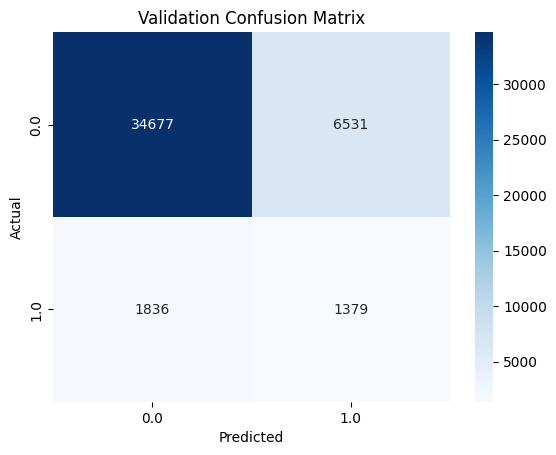

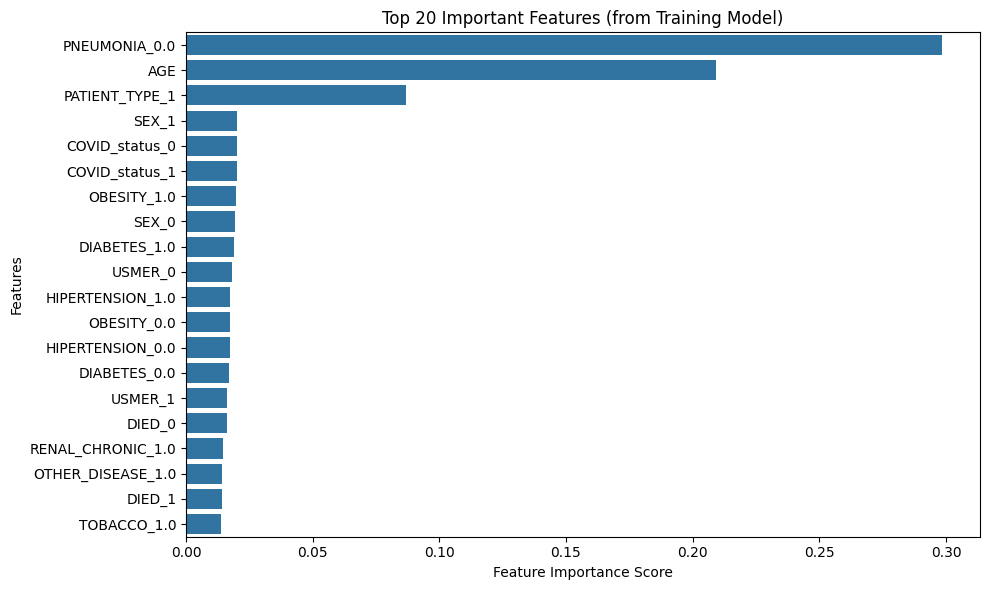

In [20]:
# === Prepare valid_df ===
valid_df = valid_df.drop(columns=["INTUBED"])
valid_df = valid_df.dropna(subset=["ICU"])
icu_valid_target = valid_df["ICU"]
valid_df = valid_df.drop(columns=["ICU"])

# Drop any remaining rows with missing values
valid_df = valid_df.dropna()
icu_valid_target = icu_valid_target.loc[valid_df.index]  # Align ICU target with cleaned DataFrame

# Convert categorical columns to string
for col in valid_df.columns:
    if col != "AGE":
        valid_df[col] = valid_df[col].astype(str)

# One-hot encode
valid_encoded = pd.get_dummies(valid_df, columns=[col for col in valid_df.columns if col != 'AGE'])

# Align columns with training features
valid_encoded_aligned = valid_encoded.reindex(columns=model_features, fill_value=0)

# Scale using the trained scaler
X_valid_scaled = loaded_scaler.transform(valid_encoded_aligned)

# Predict
y_valid_pred = loaded_clf.predict(X_valid_scaled)

# === Evaluation on validation set ===
print("\n=== Validation Metrics ===")
print("F1 Score:", f1_score(icu_valid_target, y_valid_pred, average='weighted'))
print("Accuracy:", accuracy_score(icu_valid_target, y_valid_pred))
print("Classification Report:\n", classification_report(icu_valid_target, y_valid_pred))

# === Confusion Matrix ===
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(icu_valid_target, y_valid_pred, "Validation Confusion Matrix")

# === Feature Importance (already computed from training) ===
importances = pd.Series(loaded_clf.feature_importances_, index=model_features)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 20 Important Features (from Training Model)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [ ]:
# ---------- 2. Model for PATIENT_TYPE Prediction ----------

=== Training Metrics ===
F1 Score: 0.8413722917595186
Accuracy: 0.8413724455531038
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84     83428
           1       0.84      0.84      0.84     83340

    accuracy                           0.84    166768
   macro avg       0.84      0.84      0.84    166768
weighted avg       0.84      0.84      0.84    166768


=== Test Metrics ===
F1 Score: 0.7356567838259063
Accuracy: 0.7356567207138061
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74     20802
           1       0.74      0.74      0.74     20890

    accuracy                           0.74     41692
   macro avg       0.74      0.74      0.74     41692
weighted avg       0.74      0.74      0.74     41692



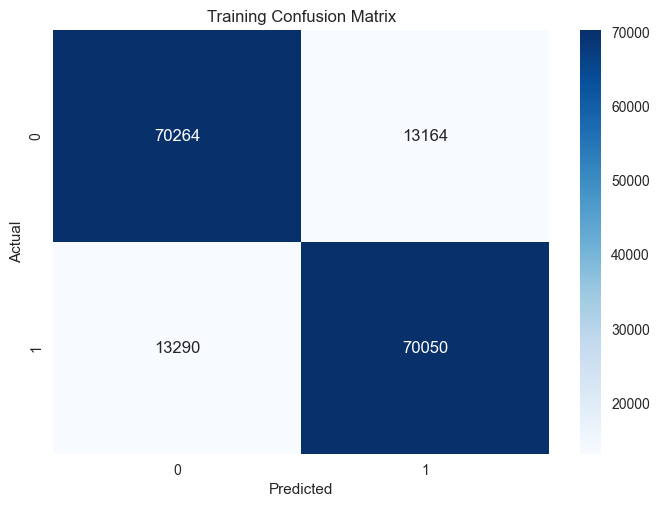

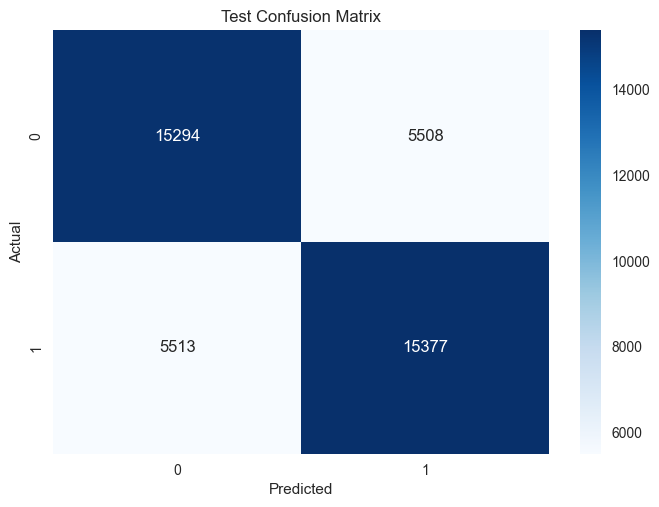

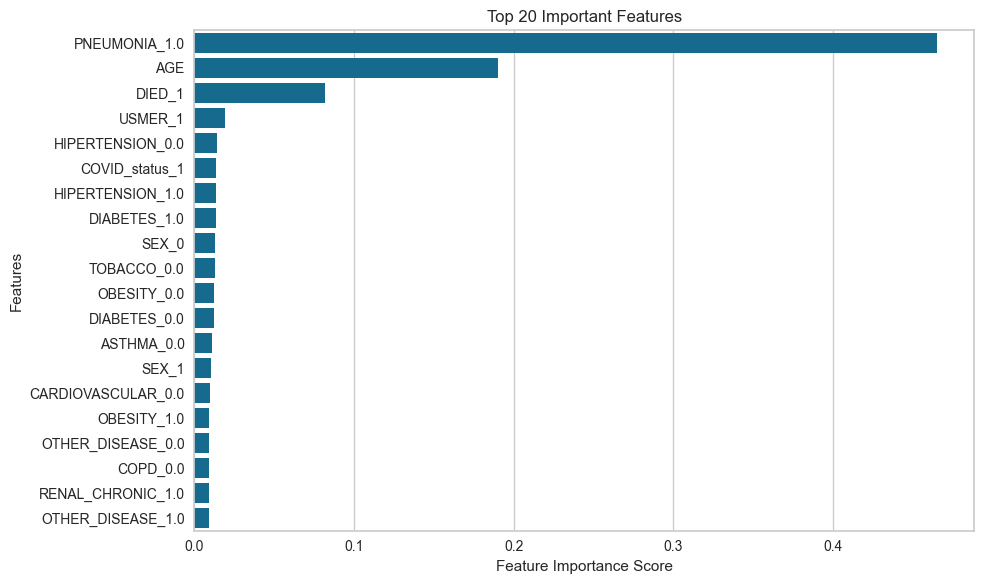

In [31]:
# Step 1: Load and clean initial data
df = pd.read_csv("imputed_covid_data_m2_modified.csv")
df = df.replace("nan", np.nan)

# Step 2: Split data into working (80%) and validation (20%)
working_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 3: Preprocess working_df
# Drop INTUBED and ICU
working_df = working_df.drop(columns=["INTUBED", "ICU"])
working_df = working_df.dropna(subset=["PATIENT_TYPE"])  # Drop rows with missing PATIENT_TYPE
patient_type_target = working_df["PATIENT_TYPE"]
working_df = working_df.drop(columns=["PATIENT_TYPE"])

# Drop all rows with any missing values (after removing target and dropped columns)
working_df = working_df.dropna()
patient_type_target = patient_type_target.loc[working_df.index]  # Align target with cleaned DataFrame

# Convert categorical columns to string
for col in working_df.columns:
    if col != "AGE":
        working_df[col] = working_df[col].astype(str)

# One-hot encode
working_encoded = pd.get_dummies(working_df, columns=[col for col in working_df.columns if col != 'AGE'])

# Step 4: Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(working_encoded, patient_type_target)

# Step 5: Scale all features (including AGE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_smote)

# Step 6: Split into train/test (from the oversampled data)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_smote, test_size=0.2, random_state=42)

# Step 7: Train classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 8: Predictions and metrics
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print("=== Training Metrics ===")
print("F1 Score:", f1_score(y_train, y_train_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

print("\n=== Test Metrics ===")
print("F1 Score:", f1_score(y_test, y_test_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Step 9: Plot confusion matrices
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_train, y_train_pred, "Training Confusion Matrix")
plot_conf_matrix(y_test, y_test_pred, "Test Confusion Matrix")

# Step 10: Feature Importance (unscaled X for feature names)
clf_unscaled = DecisionTreeClassifier(random_state=42)
clf_unscaled.fit(X_smote, y_smote)
importances = pd.Series(clf_unscaled.feature_importances_, index=working_encoded.columns)

top_features = importances.sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 20 Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [32]:
# === Save the trained PATIENT_TYPE model, scaler, and feature list ===
joblib.dump(clf, "patient_type_model.pkl")
joblib.dump(scaler, "patient_type_scaler.pkl")
joblib.dump(working_encoded.columns.tolist(), "patient_type_features.pkl")

['patient_type_features.pkl']

In [33]:
# === Load the PATIENT_TYPE model, scaler, and feature names ===
loaded_clf = joblib.load("patient_type_model.pkl")
loaded_scaler = joblib.load("patient_type_scaler.pkl")
model_features = joblib.load("patient_type_features.pkl")


=== Validation Metrics ===
F1 Score: 0.7175429089161656
Accuracy: 0.7168358733088716
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76     26035
           1       0.65      0.68      0.66     18388

    accuracy                           0.72     44423
   macro avg       0.71      0.71      0.71     44423
weighted avg       0.72      0.72      0.72     44423



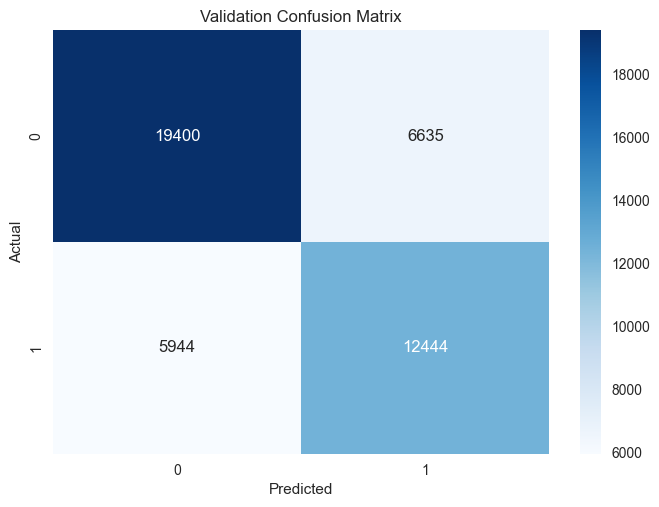

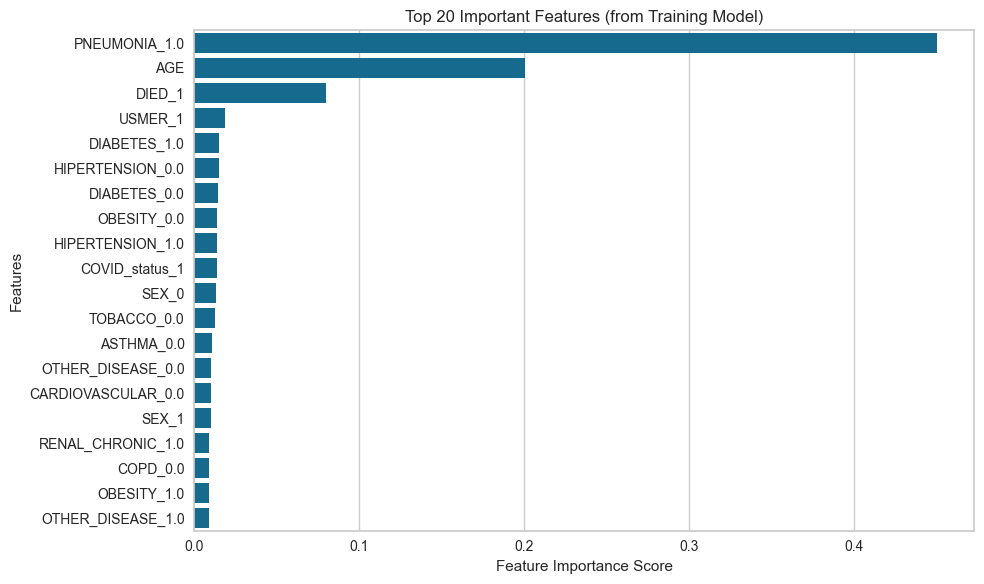

In [34]:
# === Prepare valid_df for PATIENT_TYPE prediction ===
valid_df = valid_df.drop(columns=["INTUBED", "ICU"])
valid_df = valid_df.dropna(subset=["PATIENT_TYPE"])
patient_type_valid_target = valid_df["PATIENT_TYPE"]
valid_df = valid_df.drop(columns=["PATIENT_TYPE"])

# Drop any remaining rows with missing values
valid_df = valid_df.dropna()
patient_type_valid_target = patient_type_valid_target.loc[valid_df.index]  # Align target with valid_df

# Convert categorical columns to string
for col in valid_df.columns:
    if col != "AGE":
        valid_df[col] = valid_df[col].astype(str)

# One-hot encode
valid_encoded = pd.get_dummies(valid_df, columns=[col for col in valid_df.columns if col != 'AGE'])

# Align columns with training features
valid_encoded_aligned = valid_encoded.reindex(columns=model_features, fill_value=0)

# Scale using the trained scaler
X_valid_scaled = loaded_scaler.transform(valid_encoded_aligned)

# Predict
y_valid_pred = loaded_clf.predict(X_valid_scaled)

# === Evaluation on validation set ===
print("\n=== Validation Metrics ===")
print("F1 Score:", f1_score(patient_type_valid_target, y_valid_pred, average='weighted'))
print("Accuracy:", accuracy_score(patient_type_valid_target, y_valid_pred))
print("Classification Report:\n", classification_report(patient_type_valid_target, y_valid_pred))

# === Confusion Matrix ===
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(patient_type_valid_target, y_valid_pred, "Validation Confusion Matrix")

# === Feature Importance (already computed from training) ===
importances = pd.Series(loaded_clf.feature_importances_, index=model_features)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 20 Important Features (from Training Model)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


Other Models

[LightGBM] [Info] Number of positive: 83340, number of negative: 83428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 166768, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499736 -> initscore=-0.001055
[LightGBM] [Info] Start training from score -0.001055
=== Training Metrics ===
F1 Score: 0.7088401138644808
Accuracy: 0.7158687517989063
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.56      0.66     83428
           1       0.66      0.87      0.75     83340

    accuracy                           0.72    166768
   macro avg       0.74      0.72      0.71    166768
weighted avg       0.74      0.72      0.71    166768


=== Tes

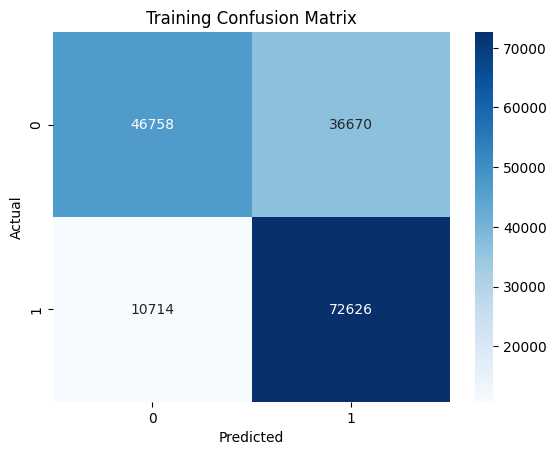

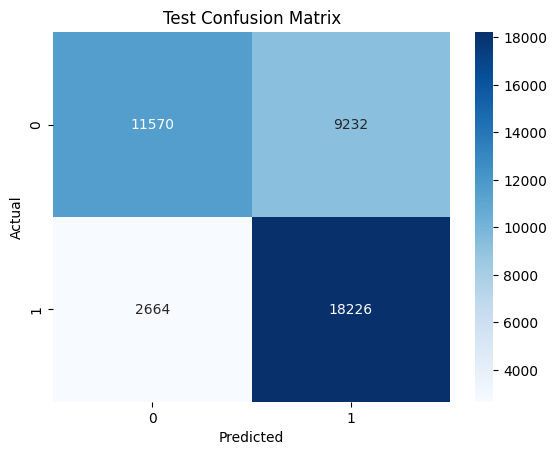

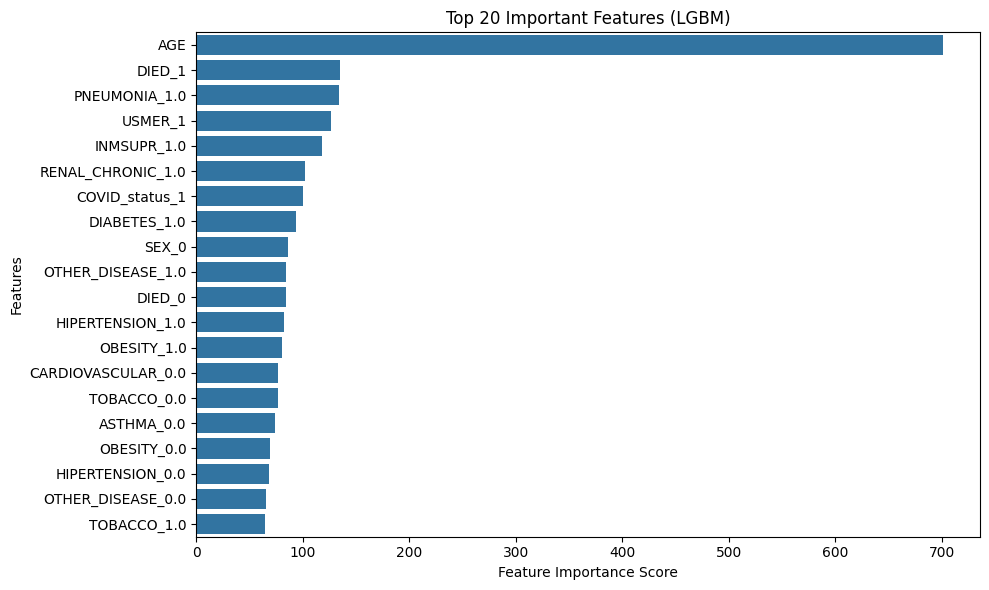

In [23]:
# Step 1: Load and clean initial data
df = pd.read_csv("imputed_covid_data_m2_modified.csv")
df = df.replace("nan", np.nan)

# Step 2: Split data into working (80%) and validation (20%)
working_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 3: Preprocess working_df
# Drop INTUBED and ICU
working_df = working_df.drop(columns=["INTUBED", "ICU"])
working_df = working_df.dropna(subset=["PATIENT_TYPE"])  # Drop rows with missing PATIENT_TYPE
patient_type_target = working_df["PATIENT_TYPE"]
working_df = working_df.drop(columns=["PATIENT_TYPE"])

# Drop all rows with any missing values (after removing target and dropped columns)
working_df = working_df.dropna()
patient_type_target = patient_type_target.loc[working_df.index]

# Convert categorical columns to string
for col in working_df.columns:
    if col != "AGE":
        working_df[col] = working_df[col].astype(str)

# One-hot encode
working_encoded = pd.get_dummies(working_df, columns=[col for col in working_df.columns if col != 'AGE'])

# Step 4: Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(working_encoded, patient_type_target)

# Step 5: Scale all features (including AGE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_smote)

# Step 6: Split into train/test (from the oversampled data)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_smote, test_size=0.2, random_state=42)

# Step 7: Train LGBM classifier
clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 8: Predictions and metrics
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print("=== Training Metrics ===")
print("F1 Score:", f1_score(y_train, y_train_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

print("\n=== Test Metrics ===")
print("F1 Score:", f1_score(y_test, y_test_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Step 9: Plot confusion matrices
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_train, y_train_pred, "Training Confusion Matrix")
plot_conf_matrix(y_test, y_test_pred, "Test Confusion Matrix")

# Step 10: Feature Importance (from LightGBM)
importances = pd.Series(clf.feature_importances_, index=working_encoded.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 20 Important Features (LGBM)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


=== Training Metrics ===
F1 Score: 0.8412509306225355
Accuracy: 0.8413544564904538
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84     83428
           1       0.82      0.87      0.85     83340

    accuracy                           0.84    166768
   macro avg       0.84      0.84      0.84    166768
weighted avg       0.84      0.84      0.84    166768


=== Test Metrics ===
F1 Score: 0.7525216707649235
Accuracy: 0.7527103521059196
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75     20802
           1       0.74      0.78      0.76     20890

    accuracy                           0.75     41692
   macro avg       0.75      0.75      0.75     41692
weighted avg       0.75      0.75      0.75     41692



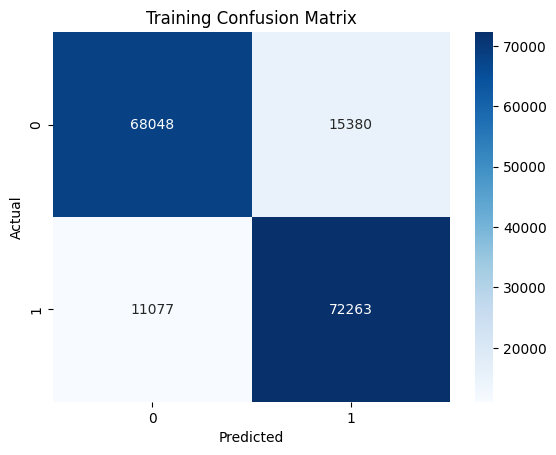

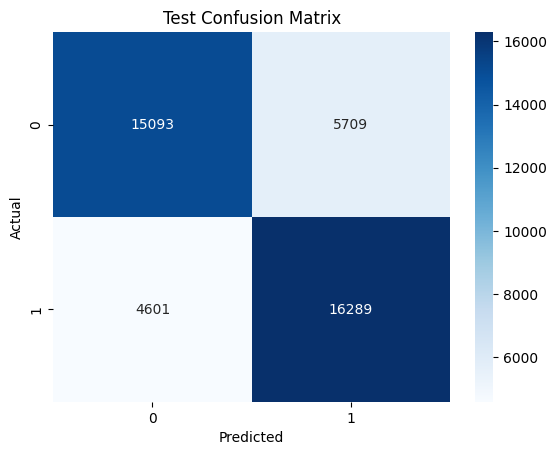

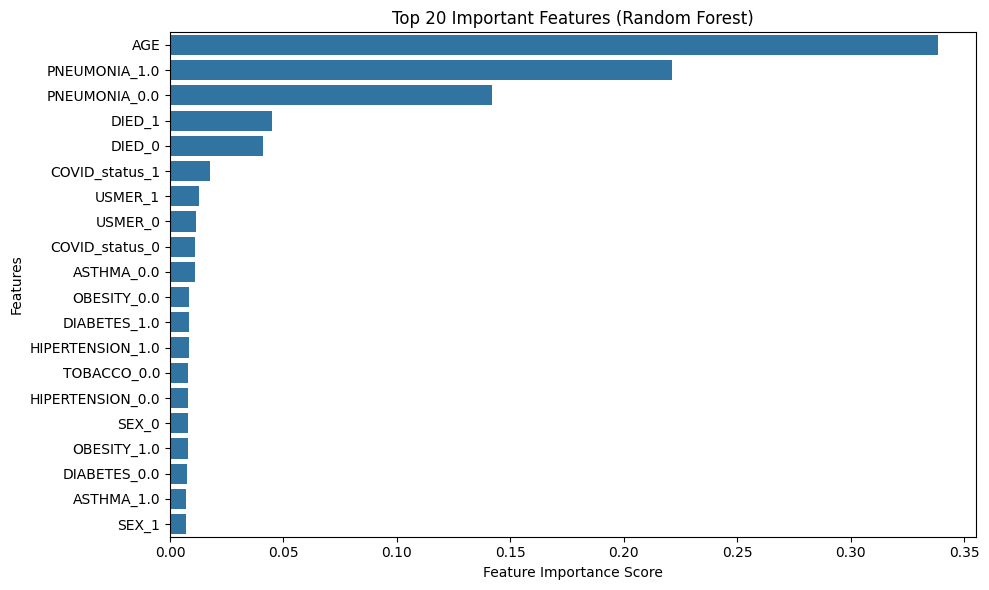

In [25]:
# Step 1: Load and clean initial data
df = pd.read_csv("imputed_covid_data_m2_modified.csv")
df = df.replace("nan", np.nan)

# Step 2: Split data into working (80%) and validation (20%)
working_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 3: Preprocess working_df
# Drop INTUBED and ICU
working_df = working_df.drop(columns=["INTUBED", "ICU"])
working_df = working_df.dropna(subset=["PATIENT_TYPE"])  # Drop rows with missing PATIENT_TYPE
patient_type_target = working_df["PATIENT_TYPE"]
working_df = working_df.drop(columns=["PATIENT_TYPE"])

# Drop all rows with any missing values (after removing target and dropped columns)
working_df = working_df.dropna()
patient_type_target = patient_type_target.loc[working_df.index]

# Convert categorical columns to string
for col in working_df.columns:
    if col != "AGE":
        working_df[col] = working_df[col].astype(str)

# One-hot encode
working_encoded = pd.get_dummies(working_df, columns=[col for col in working_df.columns if col != 'AGE'])

# Step 4: Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(working_encoded, patient_type_target)

# Step 5: Scale all features (including AGE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_smote)

# Step 6: Split into train/test (from the oversampled data)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_smote, test_size=0.2, random_state=42)

# Step 7: Train Random Forest classifier
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_train, y_train)

# Step 8: Predictions and metrics
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print("=== Training Metrics ===")
print("F1 Score:", f1_score(y_train, y_train_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

print("\n=== Test Metrics ===")
print("F1 Score:", f1_score(y_test, y_test_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Step 9: Plot confusion matrices
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_train, y_train_pred, "Training Confusion Matrix")
plot_conf_matrix(y_test, y_test_pred, "Test Confusion Matrix")

# Step 10: Feature Importance (Random Forest)
importances = pd.Series(clf.feature_importances_, index=working_encoded.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 20 Important Features (Random Forest)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd
import numpy as np
from pycaret.classification import *

# Step 1: Load and clean data
df = pd.read_csv("imputed_covid_data_m2_modified.csv")
df = df.replace("nan", np.nan)

# Step 2: Split into working (80%) and validation (20%)
working_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 3: Prepare working_df for PyCaret (drop INTUBED and ICU, drop rows with missing PATIENT_TYPE)
working_df = working_df.drop(columns=["INTUBED", "ICU"])
working_df = working_df.dropna(subset=["PATIENT_TYPE"])
working_df = working_df.dropna()  # Drop any remaining missing values

# Step 4: Setup PyCaret
clf_setup = setup(data=working_df, 
                  target='PATIENT_TYPE',
                  session_id=123,
                  categorical_features=[col for col in working_df.columns if col != "AGE" and working_df[col].dtype == 'object'],
                  numeric_features=["AGE"],
                  normalize=True,
                  remove_outliers=True,
                  imputation_type="simple",
                  use_gpu=False)

# Step 5: Compare and choose best model
best_model = compare_models()

# Step 6: Finalize the model (train on full working_df)
final_model = finalize_model(best_model)

# Step 7: Evaluate the model on training data
evaluate_model(final_model)

# Step 8: Save model and get feature importance
save_model(final_model, "pycaret_rf_patient_type_model")

# Step 9: Prepare validation data
valid_df = valid_df.drop(columns=["INTUBED", "ICU"])
valid_df = valid_df.dropna(subset=["PATIENT_TYPE"])
valid_df = valid_df.dropna()

# Step 10: Predict on validation data
preds = predict_model(final_model, data=valid_df)

# Step 11: Evaluate manually on validation
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = valid_df['PATIENT_TYPE']
y_pred = preds['Label']

print("\n=== Validation Metrics ===")
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_true, y_pred, "Validation Confusion Matrix")


,Description,Value
0,Session id,123
1,Target,PATIENT_TYPE
2,Target type,Binary
3,Original data shape,"(178232, 17)"
4,Transformed data shape,"(171993, 17)"
5,Transformed train set shape,"(118523, 17)"
6,Transformed test set shape,"(53470, 17)"
7,Numeric features,1
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7713,0.8417,0.7560,0.7113,0.7330,0.5333,0.5341,1.3640
gbc,Gradient Boosting Classifier,0.7698,0.8387,0.7682,0.7042,0.7348,0.5321,0.5337,1.6520
ada,Ada Boost Classifier,0.7673,0.8310,0.7657,0.7013,0.7321,0.5271,0.5287,0.8350
lr,Logistic Regression,0.7662,0.8270,0.7796,0.6947,0.7347,0.5270,0.5298,1.2060
ridge,Ridge Classifier,0.7624,0.8255,0.8009,0.6822,0.7368,0.5228,0.5284,0.2990
lda,Linear Discriminant Analysis,0.7621,0.8255,0.8017,0.6816,0.7368,0.5224,0.5282,0.3540
svm,SVM - Linear Kernel,0.7576,0.8092,0.8380,0.6652,0.7417,0.5190,0.5313,0.3670
qda,Quadratic Discriminant Analysis,0.7367,0.7938,0.7281,0.6677,0.6966,0.4647,0.4661,0.8640
knn,K Neighbors Classifier,0.7318,0.7811,0.6797,0.6762,0.6779,0.4482,0.4482,2.7730
nb,Naive Bayes,0.7269,0.7856,0.7335,0.6522,0.6905,0.4477,0.4502,0.4080


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Transformation Pipeline and Model Successfully Saved


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7750,0.8447,0.7588,0.7152,0.7363,0.5405,0.5412


KeyError: 'Label'

=== Training Metrics ===
F1 Score: 0.7817060634283983
Accuracy: 0.7824042981867025
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.73      0.77     83428
           1       0.75      0.84      0.79     83340

    accuracy                           0.78    166768
   macro avg       0.79      0.78      0.78    166768
weighted avg       0.79      0.78      0.78    166768


=== Test Metrics ===
F1 Score: 0.7798967135494916
Accuracy: 0.7807013335891778
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77     20802
           1       0.75      0.84      0.79     20890

    accuracy                           0.78     41692
   macro avg       0.78      0.78      0.78     41692
weighted avg       0.78      0.78      0.78     41692



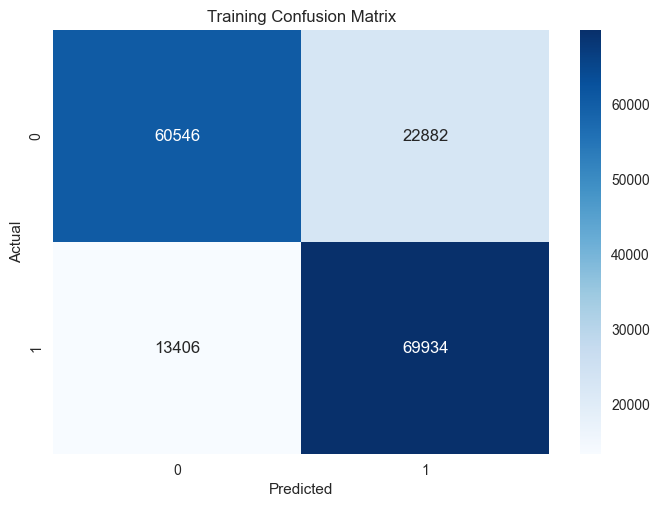

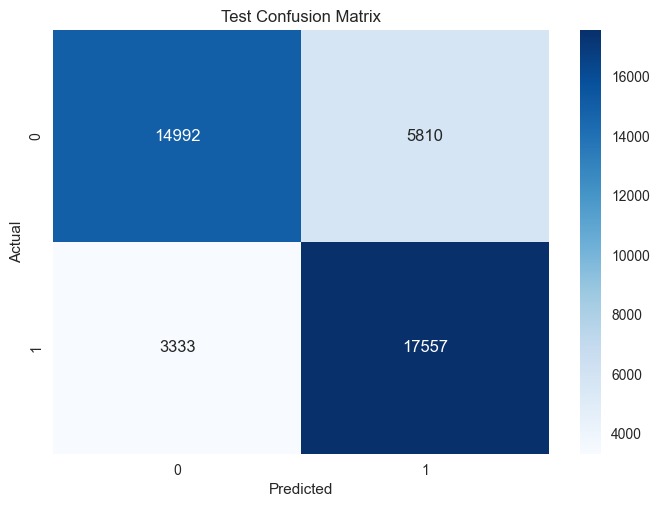

In [30]:

# Step 1: Load and clean initial data
df = pd.read_csv("imputed_covid_data_m2_modified.csv")
df = df.replace("nan", np.nan)

# Step 2: Split data into working (80%) and validation (20%)
working_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 3: Preprocess working_df
# Drop INTUBED and ICU
working_df = working_df.drop(columns=["INTUBED", "ICU"])
working_df = working_df.dropna(subset=["PATIENT_TYPE"])  # Drop rows with missing PATIENT_TYPE
patient_type_target = working_df["PATIENT_TYPE"]
working_df = working_df.drop(columns=["PATIENT_TYPE"])

# Drop all rows with any missing values (after removing target and dropped columns)
working_df = working_df.dropna()
patient_type_target = patient_type_target.loc[working_df.index]  # Align target with cleaned DataFrame

# Convert categorical columns to string
for col in working_df.columns:
    if col != "AGE":
        working_df[col] = working_df[col].astype(str)

# One-hot encode
working_encoded = pd.get_dummies(working_df, columns=[col for col in working_df.columns if col != 'AGE'])

# Step 4: Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(working_encoded, patient_type_target)

# Step 5: Scale all features (including AGE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_smote)

# Step 6: Split into train/test (from the oversampled data)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_smote, test_size=0.2, random_state=42)

# Step 7: Train Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Step 8: Predictions and metrics
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print("=== Training Metrics ===")
print("F1 Score:", f1_score(y_train, y_train_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

print("\n=== Test Metrics ===")
print("F1 Score:", f1_score(y_test, y_test_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Step 9: Plot confusion matrices
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_train, y_train_pred, "Training Confusion Matrix")
plot_conf_matrix(y_test, y_test_pred, "Test Confusion Matrix")
